# _Handwritten Image Recognition with Keras and MNIST_

![logo](images/keras.png) ![mnist](images/mnist.png)

# References:

* [Google Codelab tutorial](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..index#0)
* http://neuralnetworksanddeeplearning.com/chap1.html
* https://keras.io/
* https://keras.io/examples/mnist_cnn/
* https://www.ics.uci.edu/~mohamadt/keras_mnist.html
* [3 Brown 1 Blue - What is a neural network](https://www.youtube.com/watch?v=aircAruvnKk)
* https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
* Human Activity Recognition Comparitive - Jamie O' Halloran (Thesis - Unpublished but can show on request)

# Imports and set up

In [1]:
import numpy as np
import keras
import math

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K

from matplotlib import pyplot as plt
%matplotlib inline

print("Keras Version " + keras.__version__)

Using TensorFlow backend.
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/webapp/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/webapp/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/webapp/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as

Keras Version 2.2.5


# Set Batch Size and Number of Epochs

* [Batch size](https://stats.stackexchange.com/a/153535) => Number of samples to be propagated through network
* Epoch size => Number of times all training vectors are used to update weights
* Class size => 0 - 9 digits = 10 classes

In [2]:
batch_size = 128
epochs = 8
num_classes =10

# Load and Prepare Data Set

* Loading the data set by calling the mnist.load_data() function.
* Storing the data into arrays for the test and train set, along with their labels.
* Casting arrays as type: float32
* One hot encoding transforms categorical labels to 0s and 1s in order for the model to interpret [One Hot Encoding](https://www.youtube.com/watch?v=v_4KWmkwmsU)


In [3]:
# -- Image Dimension --
# Row / Column => 28 pixels
img_rows, img_cols = 28, 28

# -- Split Data --
# (x / y train data set)
# (x / y test data set)
# Load with => mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# -- Check Format of Image Data --
# IF:
# image_data_format => Order of dimensions [https://keras.io/layers/pooling/]
# channels_first => (batch size, feature, step) [https://keras.io/layers/pooling/]
# Reshape train data set => (shape, 1, rows, cols)
# Reshape test data set => (shape, 1, rows, cols)
# Store input shape => (1, rows, cols)
# ELSE:
# channels_last => (batch size, step, feature)
# Reshape train data => (shape, rows, cols, 1)
# Reshape test data => (shape, rows, cols, 1)
# store input shape => (rows, cols, 1)
if K.image_data_format() == 'channels_first':
    # Adapted from: https://keras.io/examples/mnist_cnn/
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)  # Store the input shape
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)  # Store the input shape

# -- Cast Data --
# Cast x_train data set as float32
# Cast x_test data set as float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# -- Scale Data --
# Divide by 255 to scale to range [0,1]
x_train /= 255
x_test /= 255

# -- Shape Verification --
# Print x train / test samples to verify re-scale
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# -- Convert Vector to Binary Matrix --
# Use with categorical crossentropy
# y train / test => Vector to be converted into matrix
# num_classes => Total number of classes
# https://keras.io/utils/
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Viewing data

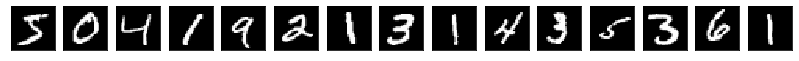

In [4]:
# Plot examples of the data.
plt.figure(1, figsize=(14,3))
for i in range(15):
    plt.subplot(1,15,i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

# Sequential Convolutional 2D Keras Model

## Convolutional 2D
* Convolutional 2D neural networkds apply a series of learnable filters to the input image.
* A conv. layer is defined by the filter size, number of filters applied and the stride. 
* The input and output of the conv. layer each have 3 dimensions (width, height and number of channels), starting with input image (width, height, RGB).
* The width and height of the output can be adjusted by using a stride > 1 or with a max-pooling operation.

[Reference](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..index#9)

### [Layer notes](https://forums.fast.ai/t/dense-vs-convolutional-vs-fully-connected-layers/191):
* Dense layer: Linear operation on the layers input vector
* Convolutional Layer: Layer that consists of filters. Filters take subset of input data at a time, then applied accross the full input. Still matrix multiplication but have to go through an activation function at output (usually non-linear operation)

## Model Glossary:
* [Sequential](https://keras.io/getting-started/sequential-model-guide/) => Linear stack of layers
* [Conv2D](https://keras.io/layers/convolutional/) => Apply spatial convolution over images
    * kernel_size => integer tuple/list of single integer, specifies 2D window
    * activation => relu (Rectified Linear Unit)
    * input_shape => 28*28 pixel image
    * use_bias => Boolean to use bias vector
    * padding => Applies extra pixels to image
    * [strides]( https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/) => New layer map will have size equal to previous layer divided by strides
* [BatchNormalization](https://keras.io/layers/normalization/) => Address how neuron outputs are distributed to activation function
    * center => beta offset normalized to tensor
    * scale => Multiply by gamma
* Dense => Linear operation on layers input vector
* Flatten => Flatten cube of data into vector that can be consumed by Dense layer
* Dense (Final) => Apply softmax transformation
    * Normalizes vector: Output probability range 0-1
    
## Compiler Glossary:
* Optimizer:
    * [Adam](https://arxiv.org/abs/1412.6980v8) => Method for Stochastic Optimization
* Loss:
    * One of two parameters required to compile a model
    * [categorical_crossentropy](https://keras.io/losses/)
* [Metrics](https://keras.io/metrics/):
    * Function used to judge performance of model
    * accuracy => Tensor value representing mean of output array across all data-points

In [5]:
# -- Create Model --
# Adapted from: @Keras Model [In link below]
# https://colab.research.google.com/github/GoogleCloudPlatform/tensorflow-without-a-phd/blob/master/tensorflow-mnist-tutorial/keras_05_mnist_batch_norm.ipynb
model = Sequential()
model.add(Conv2D(12, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(24, (3, 3), activation='relu',
                 use_bias=False, padding='same'))
model.add(BatchNormalization(center=True, scale=False))
model.add(Dense(128, activation='relu'))
model.add(Conv2D(36, (6, 6), activation='relu',
                 use_bias=False, padding='same', strides=2))
model.add(BatchNormalization(center=True, scale=False))
model.add(Dense(128, activation='relu'))
model.add(Conv2D(48, (6, 6), activation='relu',
                 use_bias=False, padding='same', strides=2))
model.add(BatchNormalization(center=True, scale=False))
model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(200, use_bias=False))
model.add(BatchNormalization(center=True, scale=False))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# -- Compile Model --
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# -- Summarise Model --
# Displays model info
# https://keras.io/models/about-keras-models/
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 12)        120       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 24)        2592      
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 24)        72        
_________________________________________________________________
dense_1 (Dense)              (None, 26, 26, 128)       3200      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 36)        165888    
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 36)        108      

# Learning Rate Schedule

* Starts the learning rate fast then decays exponentially. It sets how much the model will adjust and change in response to error produced

About Learning Rate: The learning rate identifies the speed of the learning process for each neuron. The value will be computed between 0 and 1. This multiplies with the error that each outputted value produces.

In [6]:
# -- Learning Rate Scheduler --
# Start learning rate fast then decay exponentially.
# Set how much the model will adjust and change in response to error produced.
# Learning rate identifies speed of learning process for each neuron.
# The value will be computed between 0 and 1.
# Multiply with the error produced by each outputted value.
def learningrate_decay(epoch):
    return 0.01 * math.pow(0.666, epoch)

# learning rate schedule callback
learningrate_decay_callback = keras.callbacks.LearningRateScheduler(learningrate_decay, verbose=True)

# Train the model

### Notes:
* [loss](https://stackoverflow.com/q/34673396/8883485): Scalar value that we should attempt to minimize during model training. Lower the loss, closer the predictions are to the true labels 

In [7]:
model_history = model.fit(x_train, y_train, batch_size, epochs, verbose=1,
                    validation_data=(x_test, y_test), callbacks=[learningrate_decay_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/8

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
60000/60000 [==============================] - 708s 12ms/step - loss: 0.2003 - acc: 0.9438 - val_loss: 0.1710 - val_acc: 0.9630
Epoch 2/8

Epoch 00002: LearningRateScheduler setting learning rate to 0.00666.
60000/60000 [==============================] - 760s 13ms/step - loss: 0.0749 - acc: 0.9795 - val_loss: 0.0510 - val_acc: 0.9849
Epoch 3/8

Epoch 00003: LearningRateScheduler setting learning rate to 0.004435560000000001.
60000/60000 [==============================] - 451s 8ms/step - loss: 0.0496 - acc: 0.9857 - val_loss: 0.0700 - val_acc: 0.9804
Epoch 4/8

Epoch 00004: LearningRateScheduler setting learning rate to 0.0029540829600000007.
60000/60000 [==============================] - 416s 7ms/step - loss: 0.0322 - acc: 0.9903 - val_loss: 0.0255 - val_acc: 0.9914
Ep

# Visualising predictions

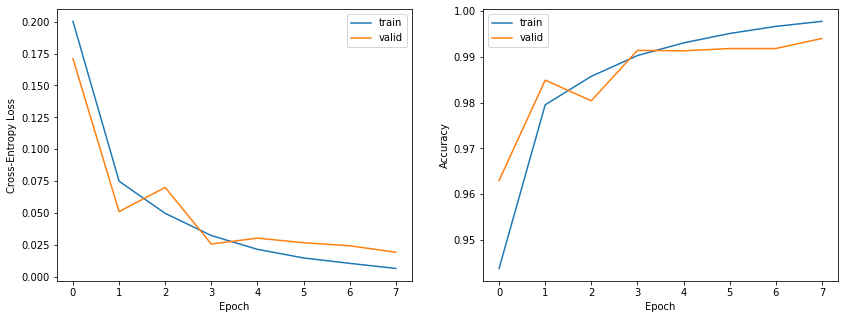

In [8]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_history.history['acc'], label='train')
plt.plot(model_history.history['val_acc'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save + Load
* https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
* https://machinelearningmastery.com/save-load-keras-deep-learning-models/#

### Notes
* Saving model weights to h5 file
    * h5: grid format that is ideal for storing muli-dim arrays of numbers
* Saving model structure as JSON

In [9]:
# Adapted from: https://machinelearningmastery.com/save-load-keras-deep-learning-models/#
# Serialize model to JSON.
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model.h5")
print("Model saved successfully")

Model saved successfully


In [10]:
# Adapted from: https://machinelearningmastery.com/save-load-keras-deep-learning-models/#
from numpy import loadtxt
from keras.models import load_model

# Deserialize json and create model
json_to_open = open('model.json', 'r')
loaded_json_model = json_to_open.read()
json_to_open.close()
model = model_from_json(loaded_json_model)

# Load weights into new model
model.load_weights("model.h5")

# Summarise model
model.summary()

# evaluate loaded model on test data
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 12)        120       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 24)        2592      
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 24)        72        
_________________________________________________________________
dense_1 (Dense)              (None, 26, 26, 128)       3200      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 36)        165888    
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 36)        108       
_________________________________________________________________
dense_2 (Dense)              (None, 13, 13, 128)      

# Evaluate the performance

In [12]:
score = model.evaluate(x_test, y_test, verbose=0) # Using previously trained model
print('Test cross-entropy loss: %0.4f' % score[0])
print('Test accuracy: %0.4f' % score[1])

Test cross-entropy loss: 0.0191
Test accuracy: 0.9940


# Visualise and inspect the output

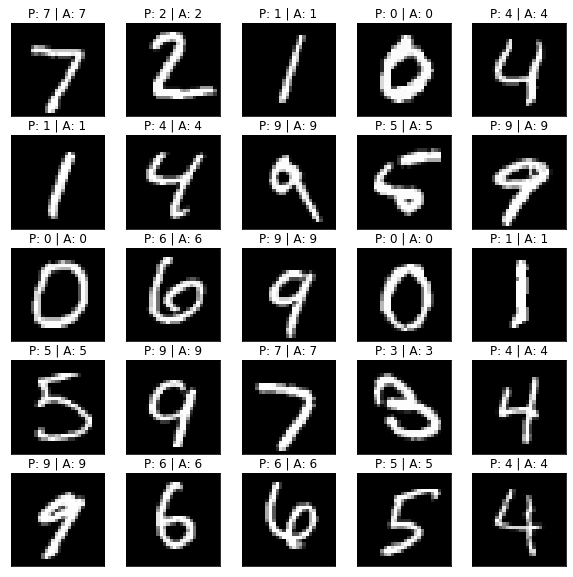

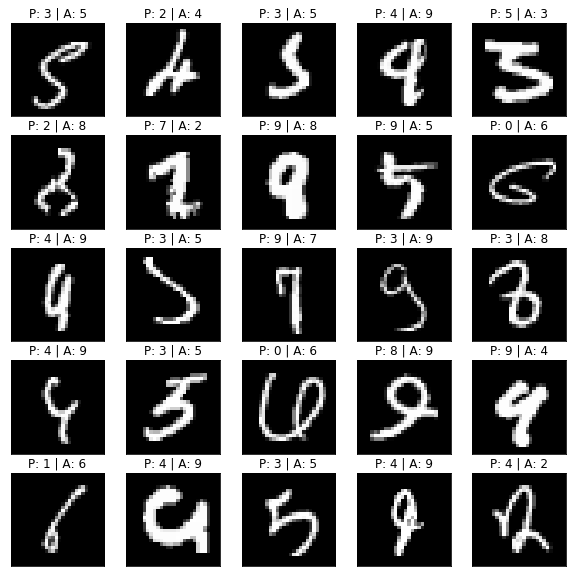

In [14]:
predicted_classes = model.predict_classes(x_test)
correct_indices   = np.nonzero(predicted_classes == y_test.argmax(axis=-1))[0]
incorrect_indices = np.nonzero(predicted_classes != y_test.argmax(axis=-1))[0]

# Plot the correct images
plt.figure(1, figsize=(10,10))
for i, correct in enumerate(correct_indices[:25]):
    plt.subplot(5,5,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
   
    # Where P --> Predicted, A --> Actual
    plt.title("P: {} | A: {}".format(predicted_classes[correct], y_test[correct].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])
    
# Plot the incorrect images
plt.figure(2, figsize=(10,10))
for i, incorrect in enumerate(incorrect_indices[:25]):
    plt.subplot(5,5,i+1)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    
    # Where P --> Predicted, A --> Actual
    plt.title("P: {} | A: {}".format(predicted_classes[incorrect], y_test[incorrect].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])